This notebook shows you how to create and query a table or DataFrame loaded from data stored in dataset.# Caltech 256 - Preprocess, processs and Feature Engineering

1. Init environment
2. Load sample data
3. Preprocess & Processes the data
4. Feature engineeing
7. Avoid small files when saving the data

In [1]:
from pyspark.sql.functions import lit
from pyspark.sql.types import BinaryType,StringType
from pyspark.sql import SparkSession

### Step 1: Set the data location and type

There are two ways to access Azure Blob storage: account keys and shared access signatures (SAS).

To get started, we need to set the location and type of the file.

In [2]:
file_location = "256_sampledata/"

### Step 2: Read the data

Now that we have specified our file metadata, we can create a DataFrame. Notice that we use an *option* to specify that we want to infer the schema from the file. We can also explicitly set this to a particular schema if we have one already.

First, let's create a DataFrame in Python.

In [3]:
! ls -l "256_sampledata"


total 0
drwxr-xr-x 106 jovyan users 3392 Nov  5  2021 196.spaghetti
drwxr-xr-x 138 jovyan users 4416 Nov  5  2021 212.teapot
drwxr-xr-x 124 jovyan users 3968 Nov  5  2021 234.tweezer
drwxr-xr-x 102 jovyan users 3264 Nov  5  2021 249.yo-yo


In [4]:
# start Spark session:

spark = SparkSession \
    .builder \
    .appName("Marshalling Image data") \
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","30g")\
    .getOrCreate()

In [5]:
spark.sql("set spark.sql.files.ignoreCorruptFiles=true")

df = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(file_location)



In [6]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [7]:
# Try image file type to learn about the schema:
# we are NOT using this DF.

image_df = spark.read.format("image") \
.option("pathGlobFilter", "*.jpg") \
.option("recursiveFileLookup", "true") \
.load(file_location)

In [8]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [9]:
image_df = None

In [10]:
df.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jovyan...|2021-11-05 14:35:...|404028|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|2021-11-05 14:35:...|291390|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|2021-11-05 14:35:...|268831|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|2021-11-05 14:35:...|222657|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|2021-11-05 14:35:...|221778|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [11]:
df.count()

462

## preprocess
 1. Extract labels
 2. Extract size
 3. transform labels to index

#### Regex expression
Notice that every path file can be different, you will need to tweak the actual regex experssion to fit your file path. for that, take a look at an example of the file path and experiement with a [regex calculator](https://regexr.com/). 

In [12]:
df.select("path").show(5, truncate=False)

+---------------------------------------------------------------------+
|path                                                                 |
+---------------------------------------------------------------------+
|file:/home/jovyan/notebooks/256_sampledata/249.yo-yo/249_0001.jpg    |
|file:/home/jovyan/notebooks/256_sampledata/196.spaghetti/196_0075.jpg|
|file:/home/jovyan/notebooks/256_sampledata/249.yo-yo/249_0016.jpg    |
|file:/home/jovyan/notebooks/256_sampledata/249.yo-yo/249_0040.jpg    |
|file:/home/jovyan/notebooks/256_sampledata/196.spaghetti/196_0070.jpg|
+---------------------------------------------------------------------+
only showing top 5 rows



In [13]:

import io
import numpy as np
import pandas as pd
import uuid
from pyspark.sql.functions import col, pandas_udf, regexp_extract
from PIL import Image

def extract_label(path_col):
  """Extract label category number from file path using built-in sql function"""
  #([^/]+)
  return regexp_extract(path_col,"256_sampledata/([^/]+)",1)

def extract_size(content):
  """Extract images size from its raw content"""
  image = Image.open(io.BytesIO(content))
  return image.size

@pandas_udf("width: int, height: int")
def extract_size_udf(content_series):
  sizes = content_series.apply(extract_size)
  return pd.DataFrame(list(sizes))

In [14]:
images_w_label_size = df.select( 
    col("path"),
    extract_label(col("path")).alias("label"),
    extract_size_udf(col("content")).alias("size"),
    col("content"))

images_w_label_size.show(5)


+--------------------+-------------+------------+--------------------+
|                path|        label|        size|             content|
+--------------------+-------------+------------+--------------------+
|file:/home/jovyan...|    249.yo-yo|{1500, 1500}|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|196.spaghetti|  {630, 537}|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|    249.yo-yo|{1792, 1200}|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|    249.yo-yo|{2048, 1536}|[FF D8 FF E0 00 1...|
|file:/home/jovyan...|196.spaghetti|  {696, 806}|[FF D8 FF E0 00 1...|
+--------------------+-------------+------------+--------------------+
only showing top 5 rows



#Transform label to index

### 1st way - the python way

In [15]:
labels = images_w_label_size.select(col("label")).distinct().collect()
label_to_idx = {label: index for index,(label,) in enumerate(sorted(labels))}
num_classes = len(label_to_idx)


@pandas_udf("long")
def get_label_idx(labels):
  return labels.map(lambda label: label_to_idx[label])

labels_idx = images_w_label_size.select( 
    col("label"),
    get_label_idx(col("label")).alias("label_index"),
    col("content"),
    col("path"),
    col("size"))

labels_idx.show(5)

+-------------+-----------+--------------------+--------------------+------------+
|        label|label_index|             content|                path|        size|
+-------------+-----------+--------------------+--------------------+------------+
|    249.yo-yo|          3|[FF D8 FF E0 00 1...|file:/home/jovyan...|{1500, 1500}|
|196.spaghetti|          0|[FF D8 FF E0 00 1...|file:/home/jovyan...|  {630, 537}|
|    249.yo-yo|          3|[FF D8 FF E0 00 1...|file:/home/jovyan...|{1792, 1200}|
|    249.yo-yo|          3|[FF D8 FF E0 00 1...|file:/home/jovyan...|{2048, 1536}|
|196.spaghetti|          0|[FF D8 FF E0 00 1...|file:/home/jovyan...|  {696, 806}|
+-------------+-----------+--------------------+--------------------+------------+
only showing top 5 rows



### 2nd way - the mllib way

In [16]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="label", outputCol="label_index")
indexed = indexer.fit(images_w_label_size).transform(images_w_label_size)

indexed.show(10)

+--------------------+-------------+------------+--------------------+-----------+
|                path|        label|        size|             content|label_index|
+--------------------+-------------+------------+--------------------+-----------+
|file:/home/jovyan...|    249.yo-yo|{1500, 1500}|[FF D8 FF E0 00 1...|        3.0|
|file:/home/jovyan...|196.spaghetti|  {630, 537}|[FF D8 FF E0 00 1...|        2.0|
|file:/home/jovyan...|    249.yo-yo|{1792, 1200}|[FF D8 FF E0 00 1...|        3.0|
|file:/home/jovyan...|    249.yo-yo|{2048, 1536}|[FF D8 FF E0 00 1...|        3.0|
|file:/home/jovyan...|196.spaghetti|  {696, 806}|[FF D8 FF E0 00 1...|        2.0|
|file:/home/jovyan...|    249.yo-yo|{1280, 1024}|[FF D8 FF E0 00 1...|        3.0|
|file:/home/jovyan...|196.spaghetti| {943, 1152}|[FF D8 FF E0 00 1...|        2.0|
|file:/home/jovyan...|    249.yo-yo|  {450, 411}|[FF D8 FF E0 00 1...|        3.0|
|file:/home/jovyan...|196.spaghetti|  {533, 375}|[FF D8 FF E0 00 1...|        2.0|
|fil

In [17]:
indexed.select("label_index").distinct().collect()

[Row(label_index=0.0),
 Row(label_index=1.0),
 Row(label_index=3.0),
 Row(label_index=2.0)]

### 3rd way - from the label itself

In [18]:
def extract_index_from_label(label):
  """Extract index  from label"""
  return regexp_extract(label,"^([^.]+)",1)

labels_idx = images_w_label_size.select( 
    col("label"),
    extract_index_from_label(col("label")).alias("label_index"),
    col("content"),
    col("path"),
    col("size"))

labels_idx.show(5,truncate=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
images_w_label_size = None

In [20]:
df = indexed

In [21]:
labels_idx = None

# Step 3: Feature Engineering
Extracting greyscale images.
Greyscale is used as an example of feature we might want to extract.

In [22]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- size: struct (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- height: integer (nullable = true)
 |-- content: binary (nullable = true)
 |-- label_index: double (nullable = false)



### calculate average image size for each category
1. flat the column into two columns
2. calculate average size for category
3. resize according to average.



In [23]:
# 1st step - flatten the struact 
flattened = df.withColumn('width', col('size')['width'])
flattened = flattened.withColumn('height', col('size')['height'])
flattened.select('width','height').show(3, truncate = False)

+-----+------+
|width|height|
+-----+------+
|1500 |1500  |
|630  |537   |
|1792 |1200  |
+-----+------+
only showing top 3 rows



In [24]:
# 2 - calculate average size for category

In [25]:
import pandas as pd
from pyspark.sql.functions import pandas_udf
from pyspark.sql import Window

@pandas_udf("int")
def pandas_mean(size: pd.Series) -> (int):
    return size.sum()

flattened.select(pandas_mean(flattened['width'])).show()
flattened.groupby("label").agg(pandas_mean(flattened['width'])).show()
flattened.select(pandas_mean(flattened['width']).over(Window.partitionBy('label'))).show()


flattened.select(pandas_mean(flattened['height'])).show()
flattened.groupby("label").agg(pandas_mean(flattened['height'])).show()
flattened.select(pandas_mean(flattened['height']).over(Window.partitionBy('label'))).show()



+------------------+
|pandas_mean(width)|
+------------------+
|            165992|
+------------------+

+-------------+------------------+
|        label|pandas_mean(width)|
+-------------+------------------+
|196.spaghetti|             39019|
|    249.yo-yo|             40944|
|  234.tweezer|             34513|
|   212.teapot|             51516|
+-------------+------------------+

+----------------------------------------------------------------+
|pandas_mean(width) OVER (PARTITION BY label unspecifiedframe$())|
+----------------------------------------------------------------+
|                                                           39019|
|                                                           39019|
|                                                           39019|
|                                                           39019|
|                                                           39019|
|                                                           39019|
|         

### Extract greyscale

In [26]:
# Sample python native function that can do additional processing - expects pandas df as input and returns pandas df as output.
def add_grayscale_img(input_df):
  # Set up return frame.  In this case I'll have a row per passed in row.  You could be aggregating down to a single image, slicing
  # out columns,or just about anything, here.  For this case, I am simply going to return the input_df with some extra columns.
  input_df['grayscale_image'] = input_df.content.apply(lambda image: get_image_bytes(Image.open(io.BytesIO(image)).convert('L'))) 
  input_df['grayscale_format'] = "png" # Since this is a pandas df, this will assigne png to all rows
  
  return input_df

def get_image_bytes(image):
  img_bytes = io.BytesIO()
  image.save(img_bytes,format="png")
  return img_bytes.getvalue()

In [27]:
# Setup the return schema. Add blank columns to match the schema expected after applying the transformation function. Makes the schema definition easy in the function invocation.
rtn_schema = (df.select('content','label','path')
                                 .withColumn('grayscale_image', lit(None).cast(BinaryType()))
                                 .withColumn('grayscale_format', lit(None).cast(StringType()))
               )
 

In [28]:
# Reduce df down to data used in the function, the groupBy, and the re-join key respectively.  This could include other features as used by your pandas function
limited_df = df.select('label','content','path')

In [29]:
# Returns spark dataframe with transformations applied in parallel for each 'group'
augmented_df = limited_df.groupBy('label').applyInPandas(add_grayscale_img, schema=rtn_schema.schema)

In [30]:
# re-join to the full dataset using leftouter in case the image transform needed to skip some rows
output_df = df.join(augmented_df.select('path','grayscale_image'),['path'],"leftouter")      

# Test on small data

In [31]:
pd_df = limited_df.limit(5).toPandas()
print(pd_df.columns)

Index(['label', 'content', 'path'], dtype='object')


In [32]:
limited_df = None

## Make sure function works correctly

In [33]:

# Some testing code
test_df = pd_df.copy()
add_grayscale_img(test_df)
print(test_df['grayscale_image'])


0    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Name: grayscale_image, dtype: object


In [34]:

from PIL import ImageFilter
# Sample python native function that can do additional processing - expects pandas df as input and returns pandas df as output.
def add_laplas(input_df):
  # Set up return frame.  In this case I'll have a row per passed in row.  You could be aggregating down to a single image, slicing
  # out columns,or just about anything, here.  For this case, I am simply going to return the input_df with some extra columns.
  input_df['edges_image'] = input_df.grayscale_image.apply(lambda image: get_image_bytes(Image.open(io.BytesIO(image)).filter(ImageFilter.FIND_EDGES)
)) 
  return input_df



In [35]:
# Some testing code
add_laplas(test_df)
print(test_df['edges_image'])

0    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4    b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Name: edges_image, dtype: object


In [36]:
print(test_df['path'][4])

file:/home/jovyan/notebooks/256_sampledata/196.spaghetti/196_0070.jpg


In [37]:
test_df

,label,content,path,grayscale_image,grayscale_format,edges_image
0,249.yo-yo,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",file:/home/jovyan/notebooks/256_sampledata/249...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,196.spaghetti,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",file:/home/jovyan/notebooks/256_sampledata/196...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,249.yo-yo,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",file:/home/jovyan/notebooks/256_sampledata/249...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,249.yo-yo,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",file:/home/jovyan/notebooks/256_sampledata/249...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,196.spaghetti,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",file:/home/jovyan/notebooks/256_sampledata/196...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [38]:
print(test_df.columns)

Index(['label', 'content', 'path', 'grayscale_image', 'grayscale_format',
       'edges_image'],
      dtype='object')


color dimensions = (537, 630, 3)
grayscale dimensions = (537, 630)


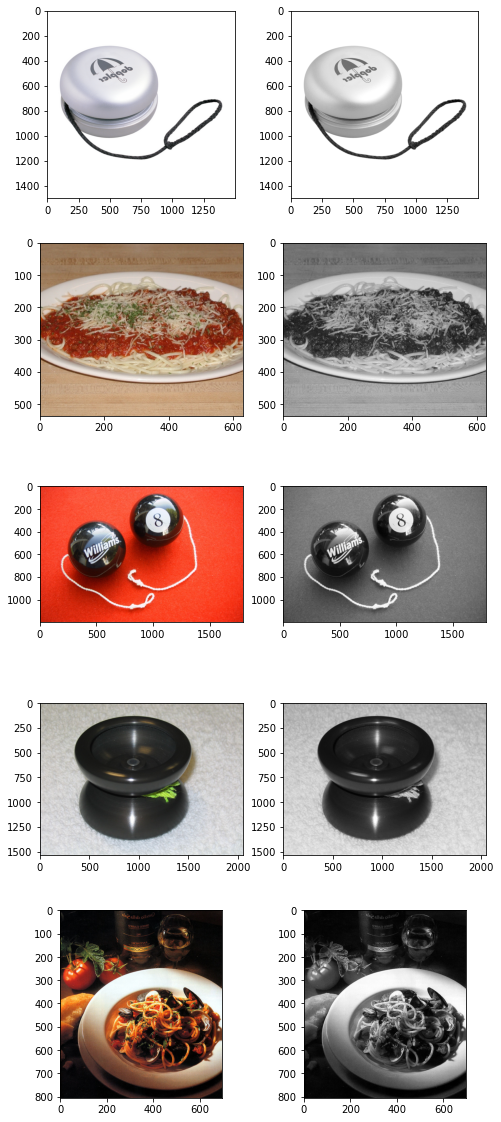

In [39]:
# display one image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

color_image = mpimg.imread(io.BytesIO(test_df.loc[1,'content']), format='jpg')
image = mpimg.imread(io.BytesIO(test_df.loc[1,'grayscale_image']), format='png')
edges_image = mpimg.imread(io.BytesIO(test_df.loc[1,'edges_image']), format='png')
print('color dimensions = {}'.format(color_image.shape))
print('grayscale dimensions = {}'.format(image.shape))

row_count = test_df.count()[0]
plt.figure(figsize=(8,20))
for label_index,row in test_df.iterrows():
  (_,content,_,grayscale,_,_) = row
  color_image = mpimg.imread(io.BytesIO(content), format='jpg')
  image = mpimg.imread(io.BytesIO(grayscale), format='png')

  plt.subplot(row_count,2,label_index*2+1)
  plt.imshow(color_image)
  plt.subplot(row_count,2,label_index*2+2)
  plt.imshow(image,cmap='gray')


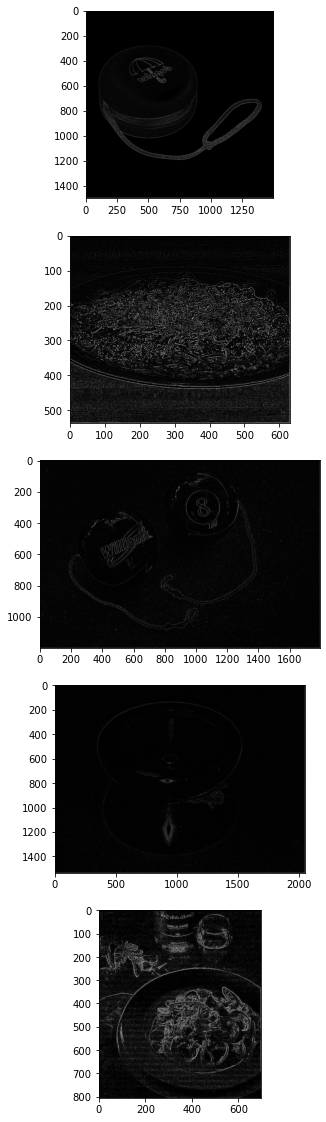

In [40]:
#laplas kernel convolution
plt.figure(figsize=(8,20))
for label_index,row in test_df.iterrows():
  (_,content,_,grayscale,_,edges_image) = row
  edges_image = image = mpimg.imread(io.BytesIO(edges_image), format='png')
    
  plt.subplot(row_count,1,label_index*1+1)
  plt.imshow(edges_image,cmap='gray')

# Full Dataset

In [41]:
output_df.show(2, truncate=True)

+--------------------+-------------+------------+--------------------+-----------+--------------------+
|                path|        label|        size|             content|label_index|     grayscale_image|
+--------------------+-------------+------------+--------------------+-----------+--------------------+
|file:/home/jovyan...|    249.yo-yo|{1500, 1500}|[FF D8 FF E0 00 1...|        3.0|[89 50 4E 47 0D 0...|
|file:/home/jovyan...|196.spaghetti|  {630, 537}|[FF D8 FF E0 00 1...|        2.0|[89 50 4E 47 0D 0...|
+--------------------+-------------+------------+--------------------+-----------+--------------------+
only showing top 2 rows



In [42]:
output_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- size: struct (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- height: integer (nullable = true)
 |-- content: binary (nullable = true)
 |-- label_index: double (nullable = false)
 |-- grayscale_image: binary (nullable = true)



# Step 5: scale the image

From the size column, we notice that caltech_256 image size highly varay. To proced with the process, we need to scale the images to have a unannimous size. For tha we will use Spark UDFs with PIL.

This is a must do part of normalizing and preprocessing image data.

In [43]:
from pyspark.sql.types import BinaryType, IntegerType
from pyspark.sql.functions import udf

img_size = 224

def scale_image(image_bytes):
    try:
      image = Image.open(io.BytesIO(image_bytes)).resize([img_size, img_size])
      return image.tobytes()
    except:
        return None

In [44]:
array = output_df.select("content").take(1)

In [45]:
from pyspark.sql.functions import udf
scale_image_udf = udf(scale_image, BinaryType())

In [46]:
#image_df = output_df.select("label_index", scale_image_udf("content").alias("content"))
image_df = output_df.select("label_index", scale_image_udf(col("content")).alias("image"))

In [47]:
image_df.printSchema()

root
 |-- label_index: double (nullable = false)
 |-- image: binary (nullable = true)



In [48]:
image_df = image_df.select("label_index","image",col("image").alias("content"))
image_df.printSchema()

root
 |-- label_index: double (nullable = false)
 |-- image: binary (nullable = true)
 |-- content: binary (nullable = true)



In [49]:
image_df =image_df.drop("image")
image_df.printSchema()

root
 |-- label_index: double (nullable = false)
 |-- content: binary (nullable = true)



# Step 4: Save and Avoid small files problem
Save the image data into a file format where you can query and process at scale

Saving the dataset with the greyscale.

### Repartition and save to **parquet**

In [50]:
# incase you are running on a distributed environment, with a large dataset, it's a good idea to partition t

# save the data:

save_path_augmented = "images_data/silver/augmented"
# Images data is already compressed so we turn off parquet compression
compression = spark.conf.get("spark.sql.parquet.compression.codec")
spark.conf.set("spark.sql.parquet.compression.codec", "uncompressed")



In [51]:
output_df.write.mode("overwrite").parquet(save_path_augmented)


In [52]:
save_path_filtered = "images_data/silver/filtered"
# parquet.block.size is for Petastorm, later
image_df.repartition(2).write.mode("overwrite").option("parquet.block.size", 1024 * 1024).parquet(save_path_filtered)

In [53]:
spark.conf.set("spark.sql.parquet.compression.codec", compression)